# Reinforcement Learning with PPO algorithm ###

In [1]:
import at
import pickle
import matplotlib.pyplot as plt
import numpy as np
import utils_ext as utils
import torch
import torchrl
from tensordict import TensorDict, TensorDictBase
from tensordict.nn import TensorDictModule
from collections import defaultdict
from torchrl.envs.common import EnvBase


from torchrl.data import Bounded, Composite, Unbounded

from typing import Optional
from tqdm import tqdm

torch.autograd.set_detect_anomaly(True, True)

## Set up simulation environment

Read lattices into memory

In [2]:
lattice_files = [f"./lattices/seed{i+1:03d}_pyAT_postRFcorrection" for i in range(100)]
rings = []
for lattice_file in lattice_files:
    with open(lattice_file,'rb') as fid:
        rings.append(pickle.load(fid))


In [3]:
import time
from multiprocessing import Process, Pipe

class LatticeEnv(EnvBase):
    """Parallelized lattice simulation training environment.

    Rings are simulated in parallel, with each given its own worker process.
    TODO: add support for mapping single worker processes to multiple rings
          to support bigger batches without the overhead of excessive context
          switching.
    """
    batch_locked = True 

    def __init__(self, rings: list[at.lattice.lattice_object.Lattice], device="cpu"):
        super().__init__(device=device, batch_size=[len(rings)])
        self.rings = rings
        self.conns = [Pipe() for _ in rings]
        self.conns, worker_conns = zip(*self.conns)
        self.workers = [Process(target=utils.worker_process, args=(ring, conn)) 
                        for ring, conn in zip(rings, worker_conns)]

        print("initializing worker processes")

        for worker in tqdm(self.workers):
            worker.start()

        self.test_conns()

        # remove?
        self.bpm_len = utils.getBPMreading(rings[0])[0].shape[0]
        self.cm_len = utils.getCorrectorStrengths(rings[0], "x").size + utils.getCorrectorStrengths(rings[0], "y").size

        self._make_spec()


    def test_conns(self):
        for conn in self.conns:
            conn.send(("ping", None))
            if conn.recv() == "received":
                pass
        print("all pipes working")


    def _step(self, tensordict):

        assert torch.all(~torch.isnan(tensordict["action"]))
        
        step_start = time.time()

        # should probably obtain this scaling constant in a better way...
        action = (tensordict["action"] * 1e-5)
        action = action.numpy(force=True)
                
        # get batched costs for current corrector magnet strengths
        corrector_start = time.time()
        for conn, action in zip(self.conns, action):
            conn.send(("step", action.copy()))
        
        costs = []
        new_bpms = []
        for conn in self.conns:
            cost, new_bpm = conn.recv()
            costs.append(cost)
            new_bpms.append(new_bpm)
        
        costs = torch.tensor(np.stack(costs), dtype=torch.float32, device=self.device)
        new_bpms = torch.tensor(np.stack(new_bpms), dtype=torch.float32, device=self.device)
                        
        reward = -costs.view(self.batch_size[0], 1)
        done = torch.zeros_like(reward, dtype=torch.bool, device=self.device)
        out = TensorDict(
            {
                "bpm": new_bpms,
                "reward": reward,
                "done": done,
            },
            tensordict.shape,
            device=self.device
        )
        #print("out cms:", out["cm"])
        #print(f"one step took {time.time() - step_start} seconds")
        return out


    def _reset(self, tensordict):
        if tensordict is not None:
            print("Not implemented!")
            return

        reset_start = time.time()

        for conn in self.conns:
            conn.send(("reset", None))

        new_bpms = []
        for conn in self.conns:
            cost, new_bpm = conn.recv()
            new_bpms.append(new_bpm)
        
        new_bpms = torch.tensor(np.stack(new_bpms), dtype=torch.float32, device=self.device)

        out = TensorDict(
            {
                "bpm": new_bpms,
            },
            batch_size=self.batch_size,
            device=self.device
        )

        #print(f"one reset took {time.time() - reset_start} seconds")
        return out


    def _make_spec(self):
        # TODO: ask about max corrector str

        self.observation_spec = Composite(
            bpm=Unbounded(shape=(self.batch_size[0], self.bpm_len, 2), 
                          dtype=torch.float32, 
                          device=self.device), 
            shape=self.batch_size,
        )

        # as this environment is stateful, could probably get rid of this
        self.state_spec = self.observation_spec.clone()

        self.action_spec = Unbounded(
            shape=(self.batch_size[0], self.cm_len),
            dtype=torch.float32,
            device=self.device
        )

        self.reward_spec = Unbounded(shape=(self.batch_size[0], 1), device=self.device)


    def _set_seed(self, seed: Optional[int]):
        # TODO: Make this actually do things... probably ask frank for a way to
        # generate new lattices/errors on the fly
        rng = torch.manual_seed(seed)
        self.rng = rng
    


Create and check base environment

In [4]:
from torchrl.envs.utils import check_env_specs

env_batch_size = 24
base_env = LatticeEnv(rings[:env_batch_size], device="cuda")
check_env_specs(base_env)

initializing worker processes


100%|██████████| 24/24 [01:08<00:00,  2.87s/it]


all pipes working
getBPMreading: 
          checking closed took 0.2405862808227539 secs
          getting BPM indices took 0.0004994869232177734 secs
          finding orbit took 0.0 secs
          finding offset took 0.003064393997192383 secs
          getting noise took 0.002683401107788086 secs


2025-01-09 16:23:37,857 [torchrl][INFO] check_env_specs succeeded!


Add necessary transforms for normalization, etc.

In [5]:
from torchrl.envs import Compose, ObservationNorm, StepCounter, TransformedEnv

env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=['bpm']),
        StepCounter(),
    ),
)

env.transform[0].init_stats(num_iter=5, reduce_dim=(0, 1, 2, 3), cat_dim=0)

check_env_specs(env)

2025-01-09 16:23:41,488 [torchrl][INFO] check_env_specs succeeded!


In [6]:
print("normalization constant shape:", env.transform[0].loc.shape)
print(env.transform[0].loc, env.transform[0].scale)

normalization constant shape: torch.Size([])
tensor(-0.0535, device='cuda:0') tensor(15961.4629, device='cuda:0')


In [7]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec:", env.action_spec)

observation_spec: Composite(
    bpm: UnboundedContinuous(
        shape=torch.Size([24, 360, 2]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([24, 360, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([24, 360, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
        device=cuda:0,
        dtype=torch.float32,
        domain=continuous),
    step_count: BoundedDiscrete(
        shape=torch.Size([24, 1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([24, 1]), device=cuda:0, dtype=torch.int64, contiguous=True),
            high=Tensor(shape=torch.Size([24, 1]), device=cuda:0, dtype=torch.int64, contiguous=True)),
        device=cuda:0,
        dtype=torch.int64,
        domain=discrete),
    device=cuda:0,
    shape=torch.Size([24]))
reward_spec: UnboundedContinuous(
    shape=torch.Size([24, 1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([24, 1]), device=cud

Perform test rollout with random policy

In [8]:
rollout = env.rollout(2)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([24, 2, 792]), device=cuda:0, dtype=torch.float32, is_shared=True),
        bpm: Tensor(shape=torch.Size([24, 2, 360, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([24, 2, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                bpm: Tensor(shape=torch.Size([24, 2, 360, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                done: Tensor(shape=torch.Size([24, 2, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                reward: Tensor(shape=torch.Size([24, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                step_count: Tensor(shape=torch.Size([24, 2, 1]), device=cuda:0, dtype=torch.int64, is_shared=True),
                terminated: Tensor(shape=torch.Size([24, 2, 1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
            batc

## Define actor and critic models

Create actor network and wrap in policy module

In [9]:
from torch import nn
from tensordict.nn import NormalParamExtractor

cm_len = env.action_spec.shape[1]
bpm_shape = env.observation_spec["bpm"].shape[1:]

device = "cuda"
actor_net = nn.Sequential(
    nn.Flatten(start_dim=-2),
    nn.LazyLinear(bpm_shape[0] * bpm_shape[1], device=device),
    nn.ReLU(),
    nn.LazyLinear(bpm_shape[0] * bpm_shape[1], device=device),
    nn.ReLU(),
    nn.LazyLinear(cm_len * 2, device=device),
    NormalParamExtractor(scale_mapping="biased_softplus_1.0", scale_lb=1e-1),
)

policy_module = TensorDictModule(
    actor_net, in_keys=["bpm"], out_keys=["loc", "scale"]
)

Create probabilistic actor using policy module

In [10]:
from torchrl.modules import ProbabilisticActor, TanhNormal, IndependentNormal, ValueOperator

policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=IndependentNormal,
    distribution_kwargs={
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

Create value network and critic module

In [11]:
bpm_len = bpm_shape[0] * bpm_shape[1]
value_net = nn.Sequential(
    nn.Flatten(start_dim=-2),
    nn.Linear(bpm_len, bpm_len, device=device),
    nn.ReLU(),
    nn.Linear(bpm_len, bpm_len, device=device),
    nn.ReLU(),
    nn.Linear(bpm_len, 1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["bpm"],
)

In [12]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([24, 792]), device=cuda:0, dtype=torch.float32, is_shared=True),
        bpm: Tensor(shape=torch.Size([24, 360, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([24, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        loc: Tensor(shape=torch.Size([24, 792]), device=cuda:0, dtype=torch.float32, is_shared=True),
        sample_log_prob: Tensor(shape=torch.Size([24]), device=cuda:0, dtype=torch.float32, is_shared=True),
        scale: Tensor(shape=torch.Size([24, 792]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([24, 1]), device=cuda:0, dtype=torch.int64, is_shared=True),
        terminated: Tensor(shape=torch.Size([24, 1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
    batch_size=torch.Size([24]),
    device=cuda:0,
    is_shared=True)
Running value: TensorDict(
    fields={
        bpm: T

## Set up PPO algorithm and replay buffer

Create data collector object

In [13]:
from torchrl.collectors import SyncDataCollector

frames_per_batch = env_batch_size * 8

outer_epochs = 128
total_frames = frames_per_batch * outer_epochs

collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
    reset_at_each_iter=True
)

We are using the replay buffer technique for enhanced training stability

In [14]:
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

Define hyperparameters, create advantage/loss modules and optimizer

In [15]:
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE

sub_batch_size = frames_per_batch  # size of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # epochs per batch of data collected from interacting w/ env
clip_epsilon = (
    0.2  # clip value for PPO loss
)
gamma = 0.7
lmbda = 0.95
entropy_eps = 1e-10#3e-4
lr = 1e-5#1e-8

advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coef=1.0,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, 
#                                                       total_frames // frames_per_batch, 
#                                                       0.0)

## Training and diagnostics

In [16]:
from tqdm import tqdm
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type


logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

eval_period = 1

max_grad_norm = 1.0


# We iterate over the collector until it reaches the total number of frames it was
# made to collect, i.e., total_frames
for i, tensordict_data in enumerate(collector):
    # For each batch of data collected, we perform num_epochs rounds of optimization
    for ep in range(num_epochs):
        # Critic network is updated in the inner loop, so need to compute
        # advantage signal too
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)

        # Instead of using the data directly, we add it to the replay buffer
        # and sample it from there
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )
            #for name, loss_val in loss_vals.items():
            #    print(f"{name}: {loss_val}")

            # perform backprop and optimize
            loss_value.backward()
            # clipping isn't necessary here but probably good anyways
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()
            
    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = f"mean reward: {logs['reward'][-1]:4.4f} (init: {logs['reward'][0]:4.4f})"
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"max steps: {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    #lr_str = f"lr policy: {logs['lr'][-1]:4.4f}"

    if i % eval_period == 0:
        # By setting the policy module to forgo exploration (take the mean of
        # the output distribution), we can accurately evaluate model performance
        with set_exploration_type(ExplorationType.MEAN), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(5, policy_module)

            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(eval_rollout["next", "reward"].sum().item())
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval reward: {logs['eval reward'][-1]:4.4f} "
                f"(init: {logs['eval reward'][0]:4.4f})"
                #f"eval max steps: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description("  ".join([eval_str, cum_reward_str]))

    # maybe use lr scheduler?
    #scheduler.step()

eval reward: -0.1766 (init: -0.1836),   mean reward: -0.3494 (init: -0.4786): 100%|██████████| 24576/24576 [13:11<00:00, 31.30it/s]

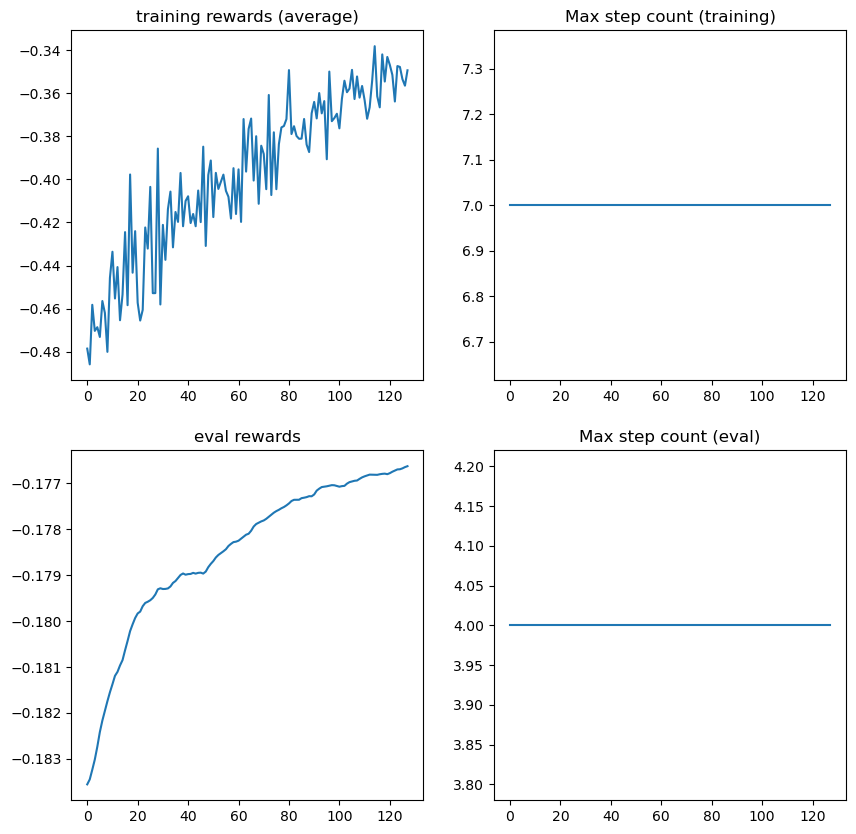

eval reward: -0.1766 (init: -0.1836),   mean reward: -0.3494 (init: -0.4786): 100%|██████████| 24576/24576 [13:23<00:00, 31.30it/s]

In [17]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward"])
plt.title("eval rewards")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (eval)")
plt.show()